<a href="https://colab.research.google.com/github/ndantuluri429/nehadant_pset2/blob/main/nehadant_hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem 1: Modeling with ClinicalBERT Embeddings

Note: to avoid consuming the GPU resources allocated to you by colab on the parts you don't need a GPU for, make sure you use a CPU runtime (Runtime > Change Runtime Type > Hardware accelerator: None) until the notebook indicates otherwise.

## Install Libraries

In [57]:
!pip install transformers
!pip install scikit-learn
!pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 5.5 MB/s eta 0:00:00


## Setting up Google Drive
Copy the data at the [following link](https://drive.google.com/drive/folders/1G5NuAnUSaKzcry-tzgPZKxafG_vcOzX9?usp=sharing) to a folder in your own drive and set the path to that folder below

In [2]:
# Path to saved data
data_path = "/content/drive/My Drive/hst_953_2022_data_hw2"

In [5]:
from google.colab import auth, drive
drive.mount('/content/drive')
auth.authenticate_user()

Mounted at /content/drive


In [6]:
import numpy as np
import pandas as pd
import os
import random
import sklearn
import importlib
import pickle
import math
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import time

from pathlib import Path
from torch.utils import data
from tqdm.auto import tqdm
from transformers import AutoTokenizer, AutoModel, BertConfig, BertTokenizer, BertForMaskedLM, InputExample

pd.set_option('display.max_columns', 50)
pd.options.mode.chained_assignment = None

# Add random seed
random.seed(456)
np.random.seed(456)

(a) You can read more about ClinicalBERT [here](https://huggingface.co/emilyalsentzer/Bio_ClinicalBERT)

In [7]:
# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

# Initialize the model
model = BertForMaskedLM.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

(b)

In [9]:
def fill_blank(text: str, model: BertForMaskedLM, tokenizer: BertTokenizer) -> str:
    '''
    Given a sentence with a single blank (denoted by an underscore), queries the BERT model to
        fill in the missing token.

    Inputs:
        - text: sentence containing a single underscore corresponding to the missing token
        - model: pytorch ClinicalBERT model, of type BertForMaskedLM
        - tokenizer: BertTokenizer object

    Output:
        - string corresponding to the sentence where the underscore is replaced with the most likely token
    '''
    random.seed(456)
    np.random.seed(456)
    torch.manual_seed(456)

    #------YOUR CODE HERE--------
    # Replace the underscore by [MASK] and store the result in masked_str
    masked_str = text.replace('_', '[MASK]')

    # Tokenize the masked string and store the tokens in inputs
    inputs = tokenizer(masked_str, return_tensors="pt")
    #------YOUR CODE ENDS--------

    inputs = inputs.to(device)
    with torch.no_grad():
        #------YOUR CODE HERE--------
        # Compute the logits (log probabilities) from the model
        logits = model(**inputs).logits
        #------YOUR CODE ENDS--------

    mask_token_index = (inputs.input_ids == tokenizer.mask_token_id)[0].nonzero(as_tuple=True)[0]

    predicted_logits = logits[0, mask_token_index]
    #------YOUR CODE HERE--------
    # Select the most likely token in predicted_logits
    predicted_token_id = torch.argmax(predicted_logits)

    # Use the tokenizer to decode the token id into a string
    pred = tokenizer.decode(predicted_token_id)
    #------YOUR CODE ENDS--------

    return text.replace('_', pred)

In [10]:
# Test fill_blank
nurse_sent = '30 yo white _ helping other nurses at the ICU'
doc_sent = '30 yo white _ helping other doctors at the ICU'
print(f"Predicted sentence: {fill_blank(nurse_sent, model, tokenizer)}")
print("Expected sentence: 30 yo white female helping other nurses at the ICU")
print(f"Predicted sentence: {fill_blank(doc_sent, model, tokenizer)}")
print("Expected sentence: 30 yo white male helping other doctors at the ICU")

Predicted sentence: 30 yo white female helping other nurses at the ICU
Expected sentence: 30 yo white female helping other nurses at the ICU
Predicted sentence: 30 yo white male helping other doctors at the ICU
Expected sentence: 30 yo white male helping other doctors at the ICU


(c)

In [11]:
#------YOUR CODE HERE--------
sent1 = "The patient was of _ descent and had an epidural."
sent2 = "The patient was of _ descent and had a cesarian section."
#------YOUR CODE ENDS--------
print(f"Sentence 1 (completed): {fill_blank(sent1, model, tokenizer)}")
print(f"Sentence 2 (completed): {fill_blank(sent2, model, tokenizer)}")

Sentence 1 (completed): The patient was of unknown descent and had an epidural.
Sentence 2 (completed): The patient was of African descent and had a cesarian section.


(d) Answer in your report

(e)

Change the runtime to GPU for this part (Runtime > Change Runtime Type > Hardware Accelerator: GPU)

In [32]:
# debug: ensure filepath is correct
from google.colab import drive
drive.mount('/content/drive')

!ls '/content/drive/My Drive/Colab Notebooks/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
'CTU Initial Explore!'	 nehadant_hw2.ipynb		    text_and_hypertension_data.h5
 nehadant_hw1.ipynb	 neha_homework1_student_ver.ipynb


In [34]:
# debug issues w/ file_path
data_path = '/content/drive/My Drive/Colab Notebooks/'

# Load the data
df = pd.read_hdf(os.path.join(data_path, "text_and_hypertension_data.h5"))

In [36]:
def get_sent_rep(model, tokenizer, txt):
    """
    Compute the sentence representation and return it as a numpy array
    If done correctly, the numpy array should be of size 768
    """
    # Tokenize the input txt and store the result in inputs
    # Remember to set truncation=True and max_length=512
    #------YOUR CODE HERE--------
    inputs = tokenizer(txt, return_tensors="pt", truncation=True, max_length=512)
    #------YOUR CODE ENDS--------
    inputs.to(device)
    model.to(device)
    with torch.no_grad():
        #------YOUR CODE HERE--------
        # Compute the model outputs and store the result in outputs
        # Make sure output_hidden_states=True
        outputs = model(**inputs, output_hidden_states=True)
        #------YOUR CODE ENDS--------

        embed = outputs.hidden_states[-1]

        #------YOUR CODE HERE--------
        # embed (of size [1, input_length, 768])
        # contains the hidden states corresponding to each
        # token at the final layer of the model
        # Each hidden state is a vector of size 768
        # Compute the mean of these vectors to get a representation
        # of the input sentence, and store the mean again in embed
        embed =  torch.mean(embed, dim=1)
        #------YOUR CODE ENDS--------

        embed = embed.squeeze()

    return embed.cpu().detach().numpy()

The following block of code should take around 15min to run on a GPU the first time it is run. Make sure to save its result in your drive to avoid needing to run it again

> Add blockquote



In [37]:
data_path = '/content/drive/My Drive/'
print(os.path.join(data_path, "embeds.npy"))

/content/drive/My Drive/embeds.npy


In [38]:
recompute_embeds = False
# Only regenerate embeds if necessary
if not os.path.exists(os.path.join(data_path, "embeds.npy")) or recompute_embeds == True:
    # Generate embeddings
    num_pts = len(df)
    embeds = [None]* num_pts
    start = time.time()
    for row_idx in range(num_pts):
        note_data = df.iloc[row_idx]["text"]
        embeds[row_idx] = get_sent_rep(model, tokenizer, note_data)
    print(time.time() - start)
    X = np.stack(embeds, axis=0)
    with open(os.path.join(data_path, "embeds.npy"), "wb") as f:
        np.save(f, X)

(f)

You can change the runtime back to CPU to avoid using your GPU allocation

In [41]:
# debug: had issues w/ libraries so had to import again
import numpy as np
import os
import pandas as pd
import pickle

from sklearn.model_selection import train_test_split

# Get train and test data
with open(os.path.join(data_path, "embeds.npy"), "rb") as f:
    # X contains one embedding per row corresponding to
    # the discharge summary of the patient in that row
    # in the dataset
    X = np.load(f)

# y contains whether the patient in a particular row had
# hypertension during their ICU stay
y = df['Hypertension'].tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=456)

In [42]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Scale the train data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

In [43]:
#------YOUR CODE HERE--------
# Create and fit your logistic regression model on the training data
# Make sure to use multi_class = "multinomial" and class_weight="balanced"

log_reg_model = LogisticRegression(multi_class="multinomial", class_weight="balanced", solver="lbfgs", max_iter=1000)
log_reg_model.fit(X_train_scaled, y_train)

#------YOUR CODE ENDS--------

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(class_weight='balanced', max_iter=1000,
                   multi_class='multinomial')

(g)

In [53]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
#------YOUR CODE HERE--------
# Compute the performance metrics on the training set

y_train_pred = log_reg_model.predict(X_train_scaled)

accuracy_train = accuracy_score(y_train, y_train_pred)
precision_train = precision_score(y_train, y_train_pred, average=None)
recall_train = recall_score(y_train, y_train_pred, average=None)
f1_train = f1_score(y_train, y_train_pred, average=None)

metrics_table_train = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision (Class 0)', 'Precision (Class 1)', 'Recall (Class 0)', 'Recall (Class 1)', 'F1-score (Class 0)', 'F1-score (Class 1)'],
    'Train': [accuracy_train, precision_train[0], precision_train[1], recall_train[0], recall_train[1], f1_train[0], f1_train[1]]
})

print('Training Set Performance Metrics:')
print(metrics_table_train)

#------YOUR CODE ENDS--------

Training Set Performance Metrics:
                Metric     Train
0             Accuracy  0.709630
1  Precision (Class 0)  0.759345
2  Precision (Class 1)  0.655014
3     Recall (Class 0)  0.707440
4     Recall (Class 1)  0.712440
5   F1-score (Class 0)  0.732474
6   F1-score (Class 1)  0.682521


In [54]:
# Scale the test data
X_test_scaled = scaler.transform(X_test)

In [55]:
#------YOUR CODE HERE--------
# Compute the performance metrics on the test set

y_test_pred = log_reg_model.predict(X_test_scaled)

accuracy_test = accuracy_score(y_test, y_test_pred)
precision_test = precision_score(y_test, y_test_pred, average=None)
recall_test = recall_score(y_test, y_test_pred, average=None)
f1_test = f1_score(y_test, y_test_pred, average=None)


metrics_table_test = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision (Class 0)', 'Precision (Class 1)', 'Recall (Class 0)', 'Recall (Class 1)', 'F1-score (Class 0)', 'F1-score (Class 1)'],
    'Test': [accuracy_test, precision_test[0], precision_test[1], recall_test[0], recall_test[1], f1_test[0], f1_test[1]]
})

print('Test Set Performance Metrics:')
print(metrics_table_test)

#------YOUR CODE HERE--------

Test Set Performance Metrics:
                Metric      Test
0             Accuracy  0.658259
1  Precision (Class 0)  0.714220
2  Precision (Class 1)  0.595471
3     Recall (Class 0)  0.664533
4     Recall (Class 1)  0.650000
5   F1-score (Class 0)  0.688481
6   F1-score (Class 1)  0.621542


(h)

In [62]:
from umap import UMAP

In [68]:
#------YOUR CODE HERE--------
# Use UMAP to project the scaled training data onto two dimensions
# Make sure to use random_state=456

umap_model = UMAP(n_neighbors=30, min_dist=0.3, metric='euclidean', random_state=456)
X_train_2d = umap_model.fit_transform(X_train_scaled)

#------YOUR CODE ENDS--------

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


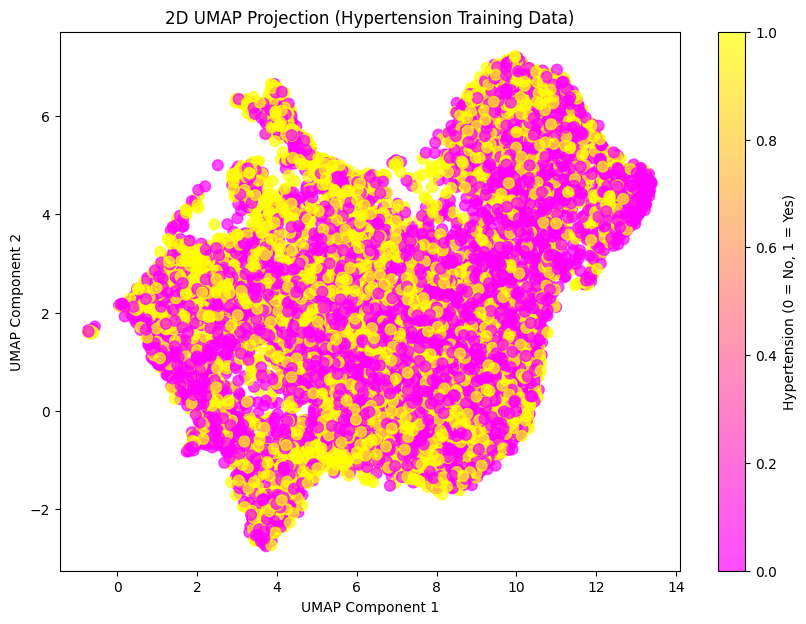

In [94]:
import matplotlib.pyplot as plt

#------YOUR CODE HERE--------
# Plot the UMAP embeddings on a scatter plot

plt.figure(figsize=(10,7))
scatter = plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1],
                      c=y_train, cmap='spring', s=60, alpha=0.7)
plt.colorbar(label='Hypertension (0 = No, 1 = Yes)')
plt.title('2D UMAP Projection (Hypertension Training Data)', fontsize = 12)
plt.xlabel('UMAP Component 1', fontsize = 10)
plt.ylabel('UMAP Component 2', fontsize = 10)
plt.show()

#------YOUR CODE ENDS--------

In [91]:
#------YOUR CODE HERE--------
# Use UMAP to project the scaled test data onto two dimensions
# Make sure to use random_state=456

umap_model = UMAP(n_neighbors=30, min_dist=0.3, metric='euclidean', random_state=456)
X_test_2d = umap_model.fit_transform(X_test_scaled)

#------YOUR CODE ENDS--------

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


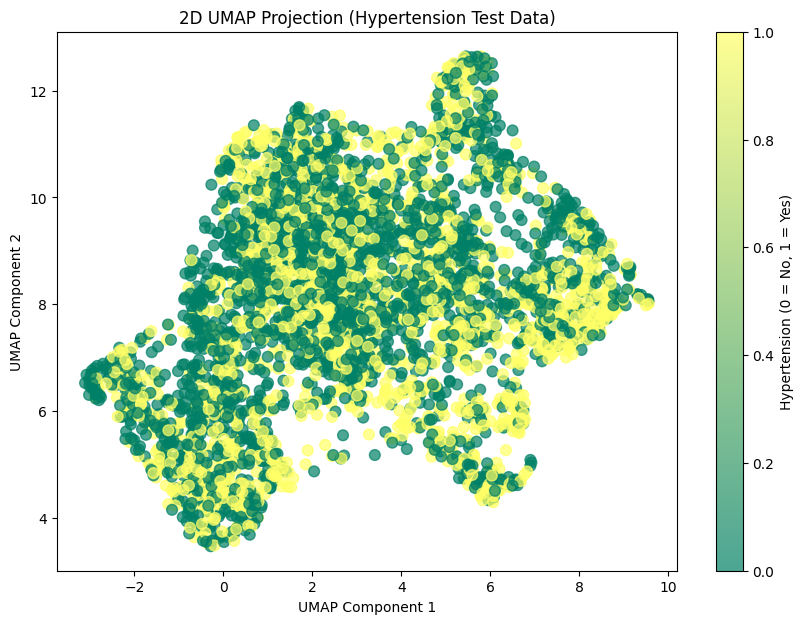

In [96]:
#------YOUR CODE HERE--------
# Plot the UMAP embeddings on a scatter plot

plt.figure(figsize=(10,7))
scatter = plt.scatter(X_test_2d[:, 0], X_test_2d[:, 1],
                      c=y_test, cmap='summer', s=60, alpha=0.7)
plt.colorbar(label='Hypertension (0 = No, 1 = Yes)')
plt.title('2D UMAP Projection (Hypertension Test Data)', fontsize=12)
plt.xlabel('UMAP Component 1', fontsize=10)
plt.ylabel('UMAP Component 2', fontsize=10)
plt.show()
#------YOUR CODE ENDS--------

(i) Answer in your report

(j)

In [99]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [101]:
#------YOUR CODE HERE--------
# Use LDA to project the scaled training data onto a single dimension

lda = LinearDiscriminantAnalysis(n_components=1)
X_train_lda = lda.fit_transform(X_train_scaled, y_train)

#------YOUR CODE ENDS--------

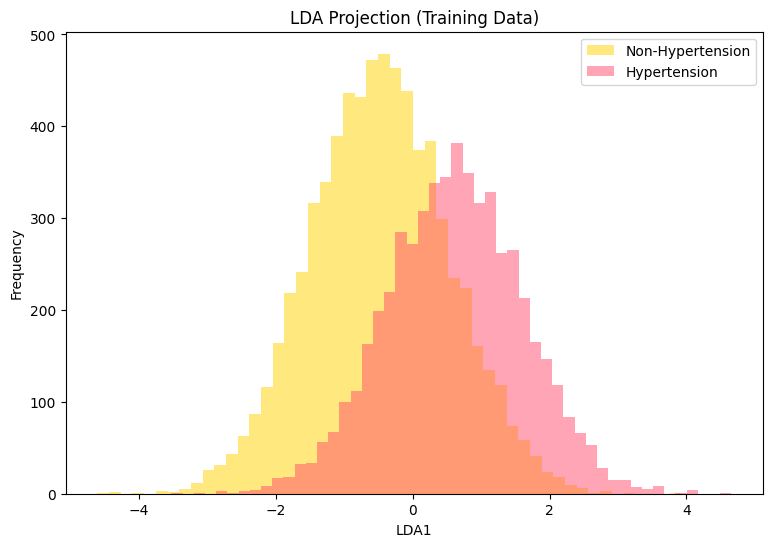

In [113]:
#------YOUR CODE HERE--------
# Plot the LDA embeddings on two histograms on the same plot

y_train = np.array(y_train)
y_train = y_train.astype(int)

plt.figure(figsize=(9,6))

plt.hist(X_train_lda[y_train == 0], bins=50, alpha=0.5, label='Non-Hypertension', color='#ffd500')
plt.hist(X_train_lda[y_train == 1], bins=50, alpha=0.5, label='Hypertension', color='#ff4d6d')

plt.title('LDA Projection (Training Data)', fontsize=12)
plt.xlabel('LDA1', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.legend()
plt.show()

#------YOUR CODE ENDS--------

In [111]:
#------YOUR CODE HERE--------
# Use LDA to project the scaled test data onto a single dimension

X_test_lda = lda.transform(X_test_scaled)

#------YOUR CODE ENDS--------

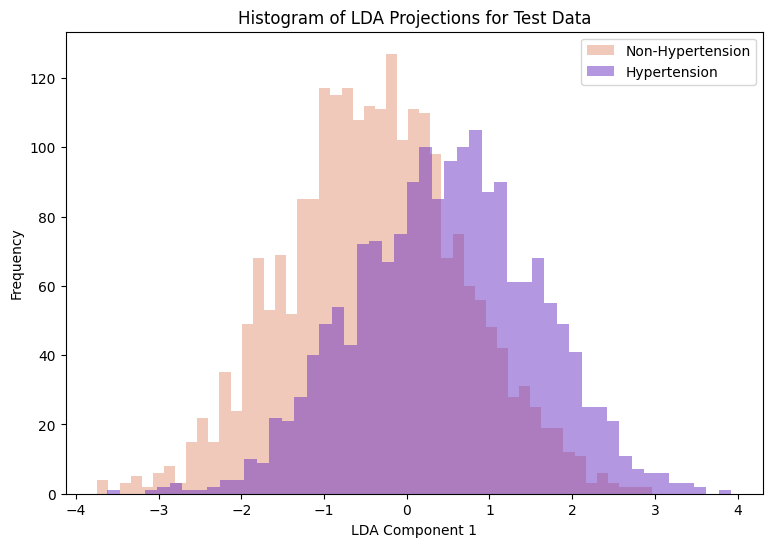

In [119]:
#------YOUR CODE HERE--------
# Plot the LDA embeddings on two histograms on the same plot

y_test= np.array(y_test)
y_test = y_test.astype(int)

plt.figure(figsize=(9,6))

plt.hist(X_test_lda[y_test == 0], bins=50, alpha=0.5, label='Non-Hypertension', color='#e29578')
plt.hist(X_test_lda[y_test == 1], bins=50, alpha=0.5, label='Hypertension', color='#6930c3')

plt.title('Histogram of LDA Projections for Test Data', fontsize=12)
plt.xlabel('LDA Component 1', fontsize=10)
plt.ylabel('Frequency', fontsize=10)

plt.legend()
plt.show()

#------YOUR CODE ENDS--------

(k) Answer in your report

(l) Answer in your report